In [1]:
import os
import gc
import heapq
import pickle
import numba as nb
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import math
from numpy import save

from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

import lightgbm

from datetime import datetime
import pytz

## README
This notebook shows the pipeline for training an LGBMRanker model with the data generated from itemCF_feature_generation_pipelines. It's very similar for orders, carts, carts model, basically needs to pick different parameters for downsampling based on the actual data size. This notebook shows the example for carts pediction.

## Load the data 

In [2]:
%%time
path = '/kaggle/input/cart-feat40-train-dataset'
batch_ids = [i for i in range(0, 41)]

df = pd.DataFrame()
for batch_id in batch_ids:
    print(f"start loading batch_{batch_id}")
    # load the batch
    temp = pd.read_parquet(f"{path}/cart_batch_result_{batch_id}.parquet").astype("float32")
    temp = temp.fillna({'gt': 0})
#     temp["action_recent_normalized"] = temp["action_recency"] / (temp["time_span"] + 0.1)
    
    df = df.append(temp, ignore_index=True).astype("float32")

del temp
gc.collect()

start loading batch_0
start loading batch_1
start loading batch_2
start loading batch_3
start loading batch_4
start loading batch_5
start loading batch_6
start loading batch_7
start loading batch_8
start loading batch_9
start loading batch_10
start loading batch_11
start loading batch_12
start loading batch_13
start loading batch_14
start loading batch_15
start loading batch_16
start loading batch_17
start loading batch_18
start loading batch_19
start loading batch_20
start loading batch_21
start loading batch_22
start loading batch_23
start loading batch_24
start loading batch_25
start loading batch_26
start loading batch_27
start loading batch_28
start loading batch_29
start loading batch_30
start loading batch_31
start loading batch_32
start loading batch_33
start loading batch_34
start loading batch_35
start loading batch_36
start loading batch_37
start loading batch_38
start loading batch_39
start loading batch_40
CPU times: user 2min 12s, sys: 2min 54s, total: 5min 6s
Wall time: 

30

### Quick Look at the data

In [3]:
df.head()

,session,aids,gt,prev_int,seq_w_total,time_w_total,ops_w_total,session_len,num_uniuqe_aids,CF_score,...,cf_incre_mean,cf_incre_min,seqW_max_min_gap,timeW_max_min_gap,opsW_max_min_gap,cf_incre_max_min_gap,last_action_raw_seq,raw_seq_sum,raw_seq_max,raw_seq_mean
0,11098528.0,11830.0,0.0,1.0,0.231144,3.0,4.0,1.0,1.0,83.211990,...,83.211990,83.211990,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,11098528.0,1732105.0,0.0,0.0,0.231144,3.0,4.0,1.0,1.0,2.773733,...,2.773733,2.773733,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,11098528.0,588923.0,0.0,0.0,0.231144,3.0,4.0,1.0,1.0,1.459935,...,1.459935,1.459935,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,11098528.0,571762.0,0.0,0.0,0.231144,3.0,4.0,1.0,1.0,0.755989,...,0.755989,0.755989,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,11098528.0,884502.0,0.0,0.0,0.231144,3.0,4.0,1.0,1.0,0.705126,...,0.705126,0.705126,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [4]:
print("df shape:", df.shape)
print("class1 shape", df[df["gt"] == 1].shape)
print("class0 shape", df[df["gt"] == 0].shape)
print("class1/0 ratio", df[df["gt"] == 1].shape[0]/df[df["gt"] == 0].shape[0])

df shape: (52530696, 42)
class1 shape (302100, 42)
class0 shape (52228596, 42)
class1/0 ratio 0.00578418765076511


In [5]:
gc.collect()

42

## train / validation / test Split

In [6]:
%%time
# 8:1:1 split
groups_1 = df["session"].values
train_temp_split = GroupKFold(n_splits=5)
for _, (idx_train, idx_temp) in enumerate(train_temp_split.split(df, groups = groups_1)):
    idx_train = idx_train
    idx_temp = idx_temp
    break

train_data = df.iloc[idx_train].astype("float32")  ## take the first 4 fold as train
temp_data = df.iloc[idx_temp].astype("float32")   ## the 5th fold as val/test

groups_2 = temp_data["session"].values
val_test_split = GroupKFold(n_splits=2)
for _, (idx_val, idx_test) in enumerate(val_test_split.split(temp_data, groups = groups_2)):
    idx_val = idx_val       
    idx_test = idx_test     
    break
    
val_data = temp_data.iloc[idx_val].astype("float32")   ## 1st fold as val
test_data = temp_data.iloc[idx_test].astype("float32")  ## 2nd fold as test

del temp_data, train_temp_split, val_test_split, groups_1, groups_2, df
gc.collect()
print("Train shape:",train_data.shape)
print("Val shape:",val_data.shape)
print("Test shape:",test_data.shape)

Train shape: (42024556, 42)
Val shape: (5253070, 42)
Test shape: (5253070, 42)
CPU times: user 17.1 s, sys: 5.84 s, total: 23 s
Wall time: 23 s


## downsample train/validation, comment out if not needed(orders might not need downsample).

In [7]:
%%time
MAINTAIN_RATIO = 0.6

train_data = train_data.drop(train_data.query('gt == 0').sample(frac=1-MAINTAIN_RATIO).index).reset_index(drop=True).astype("float32")
gc.collect()
val_data = val_data.drop(val_data.query('gt == 0').sample(frac=1-MAINTAIN_RATIO).index).reset_index(drop=True).astype("float32")
gc.collect()

CPU times: user 48.8 s, sys: 11.3 s, total: 1min
Wall time: 1min


16

## Declare all features.

In [8]:
all_features = ["prev_int", "seq_w_total", "time_w_total", "ops_w_total", "session_len", "num_uniuqe_aids", "CF_score", "itemTotalLike", "ref_time", "max_sim_score",\
    "mean_sim_score", "num_interact", "time_span", "action_recency", "seq_w_max", "seq_w_mean", "seq_w_min", "time_w_max", "time_w_mean", "time_w_min", \
        "ops_w_max", "ops_w_mean", "ops_w_min", "num_clicks", "num_carts", "num_orders", "last_action_type", "time_to_now", "cf_incre_max", "cf_incre_mean", \
            "cf_incre_min", "seqW_max_min_gap", "timeW_max_min_gap", "opsW_max_min_gap", "cf_incre_max_min_gap", "last_action_raw_seq", "raw_seq_sum", "raw_seq_max", "raw_seq_mean"]# "action_recent_normalized"]
categorical_cols = ["prev_int", "last_action_type", "opsW_max_min_gap"] 
target = 'gt'

In [9]:
%%time
## convert some variable to categorical type. 
for c in categorical_cols:
    train_data[c] = train_data[c].astype('category')
    val_data[c] = val_data[c].astype('category')
    test_data[c] = test_data[c].astype('category')

CPU times: user 5.28 s, sys: 4.23 s, total: 9.51 s
Wall time: 9.54 s


In [10]:
def get_session_lengths(df):
    return df.groupby('session')["aids"].count().to_numpy()

## get the groups
train_group = get_session_lengths(train_data)
val_group = get_session_lengths(val_data)
test_group = get_session_lengths(test_data)
print("train groups:", train_group)
print("val groups:", val_group)
print("test groups:", test_group)

train groups: [102 118 114 ...  97  85  89]
val groups: [123  84  17 ...  92 132  87]
test groups: [200 200 200 ... 151  93 151]


In [11]:
%%time
X_train, y_train = train_data[all_features].astype("float32"), train_data[target].astype("float32")
X_val, y_val = val_data[all_features].astype("float32"), val_data[target].astype("float32")
X_test, y_test = test_data[all_features].astype("float32"), test_data[target].astype("float32")

CPU times: user 2.7 s, sys: 2.5 s, total: 5.2 s
Wall time: 5.2 s


In [12]:
print("final check the shape before training")
print("train: ", X_train.shape)
print("val: ", X_val.shape)
print("test:", X_test.shape)

final check the shape before training
train:  (25311408, 39)
val:  (3163921, 39)
test: (5253070, 39)


In [13]:
gc.collect()

42

## Train the model

In [14]:
%%time
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="gbdt",
    n_estimators=5000,
    importance_type='gain',
    learning_rate=0.05,
    num_leaves=127,
    subsample=0.5,
    colsample_bytree=0.5
)


ranker.fit(
    X_train, y_train,
    group=train_group,
    eval_set=[(X_val, y_val)],
    eval_group=[val_group],
    feature_name=all_features,
    categorical_feature=categorical_cols,
    eval_at=[20],
    callbacks=[lightgbm.early_stopping(200), lightgbm.log_evaluation(200)]
          )

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['last_action_type', 'opsW_max_min_gap', 'prev_int']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 200 rounds
[200]	valid_0's ndcg@20: 0.767517
[400]	valid_0's ndcg@20: 0.767392
Early stopping, best iteration is:
[214]	valid_0's ndcg@20: 0.767596
CPU times: user 1h 37min 31s, sys: 14.2 s, total: 1h 37min 45s
Wall time: 25min 36s


LGBMRanker(colsample_bytree=0.5, importance_type='gain', learning_rate=0.05,
           metric='ndcg', n_estimators=5000, num_leaves=127,
           objective='lambdarank', subsample=0.5)

## Model Validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

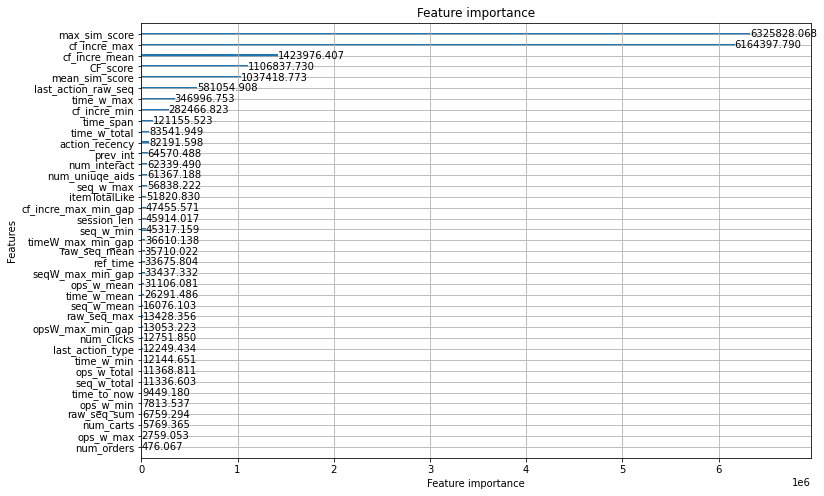

In [15]:
lightgbm.plot_importance(ranker, figsize = (12,8))

In [16]:
test_result_df = test_data.copy().astype("float32")
test_result_df["y_pred"] = ranker.predict(X_test)
test_result_df["lgbm_rank"] = test_result_df.groupby("session")['y_pred'].rank(method="first", ascending=False)
test_result_df["CFScore_rank"] = test_result_df.groupby("session")['CF_score'].rank(method="first", ascending=False)

### @20 Recall correct rate comparison

In [17]:
TOP_K = 20
print("total class 1 that can be predicted")
print(test_result_df[(test_result_df["gt"] == 1)].shape)
print(f"Correct Pred by lgbm ranker by taking top {TOP_K}")
print(test_result_df[(test_result_df["gt"] == 1) & (test_result_df["lgbm_rank"] <= TOP_K)].shape)
print(f"Correct Pred by cf score by taking top {TOP_K }")
print(test_result_df[(test_result_df["gt"] == 1) & (test_result_df["CFScore_rank"] <= TOP_K)].shape)

total class 1 that can be predicted
(30217, 45)
Correct Pred by lgbm ranker by taking top 20
(23875, 45)
Correct Pred by cf score by taking top 20
(23605, 45)


In [18]:
recall_limit = [i for i in range(1, 21)]
lgbm_ranker_correct_pred = []
cf_score_correct_pred = []
for limit in recall_limit:
    lgbm_ranker_correct_pred.append(test_result_df[(test_result_df["gt"] == 1) & (test_result_df["lgbm_rank"] <= limit)].shape[0])
    cf_score_correct_pred.append(test_result_df[(test_result_df["gt"] == 1) & (test_result_df["CFScore_rank"] <= limit)].shape[0])

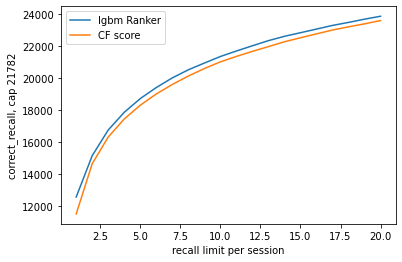

In [19]:
import matplotlib.pyplot as plt

plt.plot(recall_limit, lgbm_ranker_correct_pred, label = "lgbm Ranker")
plt.plot(recall_limit, cf_score_correct_pred, label = "CF score")
plt.xlabel("recall limit per session")
plt.ylabel("correct_recall, cap 21782")
plt.legend()
plt.show()

## Save the model as artifact/txt.

In [20]:
model_name = '0_4_downsample_full_batch_read'
ranker.booster_.save_model(f'model_cart_{model_name}.txt')